# MadMiner particle physics tutorial

# Part 4c: Information Geometry

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

## 0. Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
import os
madminer_src_path = '/home/llr/cms/cortinovis/miner/MG5_aMC_v2_6_7'
sys.path.append(madminer_src_path)


import six
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.fisherinformation import FisherInformation, InformationGeometry
from madminer.plotting import plot_fisher_information_contours_2d


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

Let's look at a simple example to unserstand what happens in information geometry. At first we note that the Fisher Information is a symmetric positive definite rank two tensor, and therefore can be seen as a Riemanian metric. It can therefore be used to calculate distances between points in parameter space. 

Previously, in tutorial 4b, we have considered the **local distance** $d_{local}(\theta,\theta_0)$ between two points $\theta$ and $\theta_0$. It is defined in the tangent space of $\theta_0$, where the metric is constant and hence flat, and can simply be calculated as $d_{local}(\theta,\theta_0) = I_{ij}(\theta_0) \times (\theta-\theta_0)^i (\theta-\theta_0)^j$. 

Going beyond this local approximation, we can calculate a **global distance** $d_{global}(\theta,\theta_0)$ which takes into account the fact that the information is not constant throughout the parameter space. Using our knowledge from general relativity, this distance is defined as
\begin{equation}
 d(\theta,\theta_0)= \text{min} \int_{\theta_0}^{\theta} ds \sqrt{I_{ij}(\theta(s)) \frac{d\theta^i}{ds}\frac{d\theta^j}{ds}} 
\end{equation}
where $\theta(s)$ is the geodesic (the shortest path) connecting $\theta_0$ and $\theta$. This path is follows the geodesic equation 
\begin{equation}
 \frac{d^2\theta^i}{ds^2} = - \Gamma^i_{jk} \frac{d\theta^j}{ds}\frac{d\theta^k}{ds} \quad \text{with} \quad
 \Gamma^i_{jk} = \frac{1}{2} I^{im} \Big(\frac{\partial I_{mk}}{\partial \theta^j} + \frac{\partial I_{mj}}{\partial \theta^k} - \frac{\partial I_{jk}}{\partial \theta^m}\Big) \quad \text{and} \quad I^{im} I_{mj} = \delta^i_j \ . 
\end{equation}
In practice, we obtain the geodesics by numerically integrating the geodesic equation, starting at a parameter point $\theta_0$ with a velocity $\theta'_0=(\theta/ds)_0$

## 1. Stand Alone Example

In the following, we consider a sample geometry with Fisher Information $I_{ij}(\theta)= (( 1+\theta_1/4 , 1 ),( 1 ,  2-\theta_2/2))$ and determine the geodesics and distance contours for illistration. At first, we initialize a new class `InformationGeometry` and define the Fisher Information via the function `information_from_formula()`. 

In [3]:
formula="np.array([[1 + 0.25*theta[0] ,1],[1, 2 - 0.5*theta[1]  ]])"

infogeo=InformationGeometry()
infogeo.information_from_formula(formula=formula,dimension=2)

Now we obtain one particular geodesic path staring at $\theta_0$ in the direction of $\Delta \theta_0$ using the function `find_trajectory()`.   

In [4]:
thetas,distances=infogeo.find_trajectory(
    theta0=np.array([0.,0.]),
    dtheta0=np.array([1.,1.]),
    limits=np.array([[-1.,1.],[-1.,1.]]),
    stepsize=0.025,
)

For comparisson, let's do the same for a constant Fisher Information $I_{ij}(\theta)=I_{ij}(\theta_0)=((1,1),(1,2))$. 

In [5]:
formula_lin="np.array([[1 ,1],[1, 2 ]])"
infogeo_lin=InformationGeometry()
infogeo_lin.information_from_formula(formula=formula_lin,dimension=2)
thetas_lin,distances_lin=infogeo_lin.find_trajectory(
    theta0=np.array([0.,0.]),
    dtheta0=np.array([1.,1.]),
    limits=np.array([[-1.,1.],[-1.,1.]]),
    stepsize=0.025,
)

/home/llr/cms/cortinovis/.local/lib/python3.7/site-packages/madminer/fisherinformation.py:1928: RuntimeWarning: divide by zero encountered in double_scalars
  max_stepsize = 0.05 * np.linalg.norm(dtheta) / np.linalg.norm(ddtheta)


and plot the results

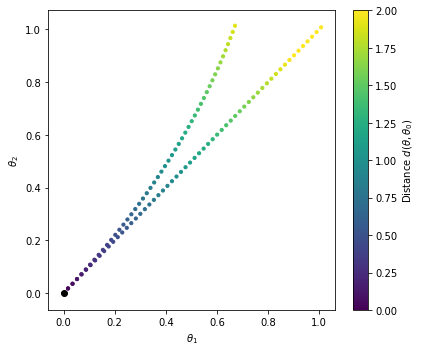

In [6]:
cmin, cmax = 0., 2
fig = plt.figure(figsize=(6,5))

plt.scatter(
    thetas_lin.T[0],thetas_lin.T[1],c=distances_lin,
    s=10., cmap='viridis',marker='o',vmin=cmin, vmax=cmax,
)
sc = plt.scatter(
    thetas.T[0],thetas.T[1],c=distances,
    s=10., cmap='viridis',marker='o',vmin=cmin, vmax=cmax,
)
plt.scatter( [0],[0],c='k')

cb = plt.colorbar(sc)
cb.set_label(r'Distance $d(\theta,\theta_0)$')

plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.tight_layout()
plt.show()

We can see that the geodesic trajectory is curved. The colorbar denotes the distance from the origin.  

Let us now see how we can construct the distance contours using the function `distance_contours`. 

In [7]:
grid_ranges = [(-1, 1.), (-1, 1.)]
grid_resolutions = [25, 25]

theta_grid,p_values,distance_grid,(thetas,distances)=infogeo.distance_contours(
    np.array([0.,0.]),
    grid_ranges=grid_ranges, 
    grid_resolutions=grid_resolutions,
    stepsize=0.08,
    ntrajectories=30,
    continous_sampling=True,
    return_trajectories=True,   
)

and plot the results

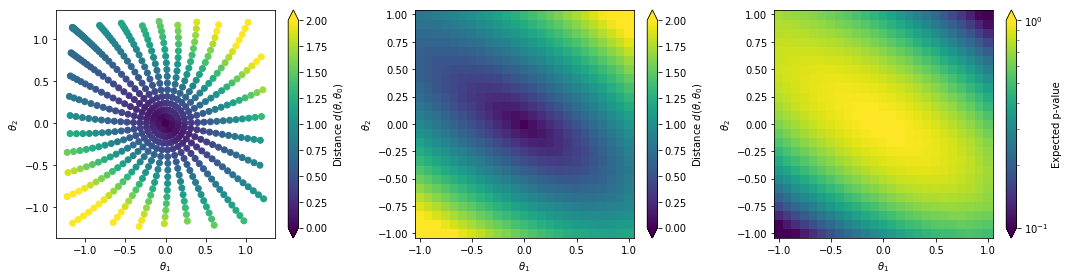

In [8]:
#Prepare Plot
cmin, cmax = 0., 2
fig = plt.figure(figsize=(15.0, 4.0 ))

bin_size = (grid_ranges[0][1] - grid_ranges[0][0])/(grid_resolutions[0] - 1)
edges = np.linspace(grid_ranges[0][0] - bin_size/2, grid_ranges[0][1] + bin_size/2, grid_resolutions[0] + 1)
centers = np.linspace(grid_ranges[0][0], grid_ranges[0][1], grid_resolutions[0])

#Plot
ax = plt.subplot(1,3,1)
sc = ax.scatter(thetas.T[0],thetas.T[1],c=distances,vmin=cmin, vmax=cmax,)
cb = plt.colorbar(sc,ax=ax, extend='both')
cb.set_label(r'Distance $d(\theta,\theta_0)$')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')


ax = plt.subplot(1,3,2)
cm = ax.pcolormesh(
    edges, edges, distance_grid.reshape((grid_resolutions[0], grid_resolutions[1])).T,
    vmin=cmin, vmax=cmax,
    cmap='viridis'
)
cb = plt.colorbar(cm, ax=ax, extend='both')
cb.set_label(r'Distance $d(\theta,\theta_0)$')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')


ax = plt.subplot(1,3,3)
cm = ax.pcolormesh(
    edges, edges, p_values.reshape((grid_resolutions[0], grid_resolutions[1])).T,
    norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=1),
    cmap='viridis'
)
cb = plt.colorbar(cm, ax=ax, extend='both')
cb.set_label('Expected p-value')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')


plt.tight_layout()
plt.show()

The left plot shows the distance values along generated geodesics. These values are interpolated into a continuous function shown in the middle plot. In the right plot we convert the distances into expected p-values. 

## 2. Information Geometry Bounds for Example Process 

Now that we understand how Information Geometry works in principle, let's apply it to our example process. Let's first create a grid of theta values

In [9]:
def make_theta_grid(theta_ranges, resolutions):
        theta_each = []
        for resolution, (theta_min, theta_max) in zip(resolutions, theta_ranges):
            theta_each.append(np.linspace(theta_min, theta_max, resolution))
        theta_grid_each = np.meshgrid(*theta_each, indexing="ij")
        theta_grid_each = [theta.flatten() for theta in theta_grid_each]
        theta_grid = np.vstack(theta_grid_each).T
        return theta_grid
    
grid_ranges = [(-1, 1.), (-1, 1.)]
grid_resolutions = [25, 25]
theta_grid = make_theta_grid(grid_ranges,grid_resolutions)

Now we create a grid of Fisher Informations. Since this might take some time, we already prepared the results, which can be loaded directly.

In [10]:
model='alices'
calculate_fisher_grid=False
if calculate_fisher_grid:
    fisher = FisherInformation('data/lhe_data_shuffled.h5')
    fisher_grid=[]

    for theta in theta_grid:
        fisher_info, _ = fisher.full_information(
            theta=theta,
            model_file='models/'+model,
            luminosity=300.*1000.,
            include_xsec_info=False,
        )
        fisher_grid.append(fisher_info)
    np.save("limits/infogeo_thetagrid_"+model+".npy", theta_grid)
    np.save("limits/infogeo_fishergrid_"+model+".npy", fisher_grid)
else: 
    theta_grid=np.load("limits/infogeo_thetagrid_"+model+".npy")
    fisher_grid=np.load("limits/infogeo_fishergrid_"+model+".npy")

In the next step, we initialize the `InformationGeoemtry` class using this input data. Using the function `information_from_grid()`, the provided grid is interpolated using a piecewise linear function and the information can be calculated at every point. 

In [11]:
infogeo=InformationGeometry()
infogeo.information_from_grid(
    theta_grid="limits/infogeo_thetagrid_"+model+".npy", 
    fisherinformation_grid="limits/infogeo_fishergrid_"+model+".npy",
)

18:39 madminer.utils.vario INFO      Loading limits/infogeo_thetagrid_alices.npy into RAM
18:39 madminer.utils.vario INFO      Loading limits/infogeo_fishergrid_alices.npy into RAM


As before, we can now obtain the p-values using the `distance_contours()` function

In [12]:
theta_grid,p_values_infogeo,distance_grid,(thetas,distances)=infogeo.distance_contours(
    np.array([0.,0.]),
    grid_ranges=grid_ranges, 
    grid_resolutions=grid_resolutions,
    stepsize=0.05,
    ntrajectories=300,
    return_trajectories=True,   
)

and plot it again

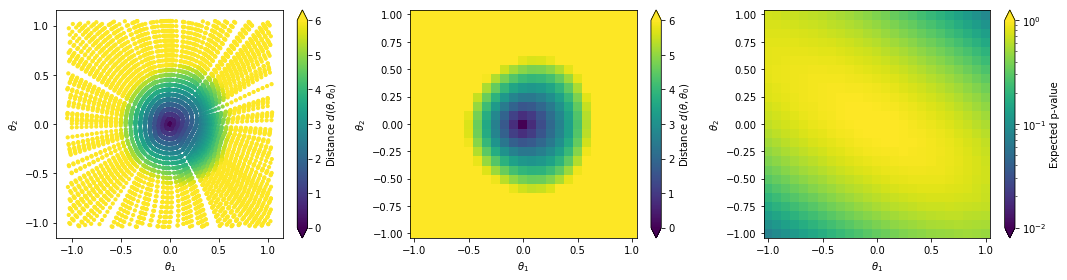

In [13]:
#Prepare Plot
cmin, cmax = 0., 6
fig = plt.figure(figsize=(15.0, 4.0 ))

bin_size = (grid_ranges[0][1] - grid_ranges[0][0])/(grid_resolutions[0] - 1)
edges = np.linspace(grid_ranges[0][0] - bin_size/2, grid_ranges[0][1] + bin_size/2, grid_resolutions[0] + 1)
centers = np.linspace(grid_ranges[0][0], grid_ranges[0][1], grid_resolutions[0])

#Plot
ax = plt.subplot(1,3,1)
sc = ax.scatter(thetas.T[0],thetas.T[1],c=distances,vmin=cmin, vmax=cmax,s=10,)
cb = plt.colorbar(sc,ax=ax, extend='both')
cb.set_label(r'Distance $d(\theta,\theta_0)$')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')


ax = plt.subplot(1,3,2)
cm = ax.pcolormesh(
    edges, edges, distance_grid.reshape((grid_resolutions[0], grid_resolutions[1])).T,
    vmin=cmin, vmax=cmax,
    cmap='viridis'
)
cb = plt.colorbar(cm, ax=ax, extend='both')
cb.set_label(r'Distance $d(\theta,\theta_0)$')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')


ax = plt.subplot(1,3,3)
cm = ax.pcolormesh(
    edges, edges, p_values.reshape((grid_resolutions[0], grid_resolutions[1])).T,
    norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1),
    cmap='viridis'
)
cb = plt.colorbar(cm, ax=ax, extend='both')
cb.set_label('Expected p-value')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')


plt.tight_layout()
plt.show()

## 3. Compare to other results

Load previous results and add Information Geometry results

In [14]:
[p_values,mle]=np.load("limits/limits.npy", allow_pickle=True)

p_values["InfoGeo"] = p_values_infogeo.flatten()
mle["InfoGeo"] = 312

and plot them together with the obtained Information Geometry results

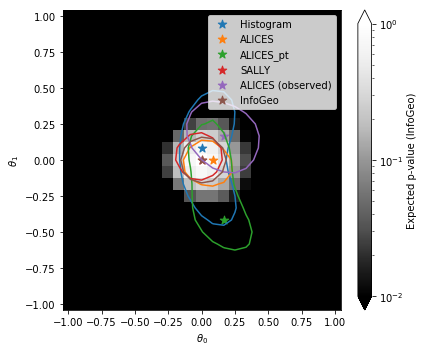

In [15]:
show = "InfoGeo"

bin_size = (grid_ranges[0][1] - grid_ranges[0][0])/(grid_resolutions[0] - 1)
edges = np.linspace(grid_ranges[0][0] - bin_size/2, grid_ranges[0][1] + bin_size/2, grid_resolutions[0] + 1)
centers = np.linspace(grid_ranges[0][0], grid_ranges[0][1], grid_resolutions[0])

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

cmin, cmax = 1.e-2, 1.

pcm = ax.pcolormesh(
    edges, edges, p_values[show].reshape((grid_resolutions[0], grid_resolutions[1])).T,
    norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
    cmap='Greys_r'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    plt.contour(
        centers, centers, p_value.reshape((grid_resolutions[0], grid_resolutions[1])).T,
        levels=[0.32],
        linestyles='-', colors='C{}'.format(i)
    )
    plt.scatter(
        theta_grid[mle[label]][0], theta_grid[mle[label]][1],
        s=80., color='C{}'.format(i), marker='*',
        label=label
    )

plt.legend()

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Expected p-value ({})'.format(show))

plt.tight_layout()
plt.show()


Finally, we compare the obtained distance $d(\theta,\theta_0)$ with the expected log-likelihood ratio $q(\theta,\theta_0) = E[-2 \log r(x|\theta,\theta_0)|\theta_0]$. We can see that there is an approximately linear relationship. 

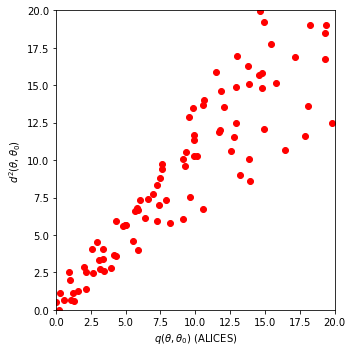

In [16]:
from scipy.stats.distributions import chi2

#Prepare Plot
cmin, cmax = 0., 6
fig = plt.figure(figsize=(5.0, 5.0 ))

#Plot
ax = plt.subplot(1,1,1)
ax.scatter(chi2.ppf(1-p_values["ALICES"], df=2),distance_grid.flatten()**2,c="red",)
ax.set_xlabel(r'$q(\theta,\theta_0)$ (ALICES)')
ax.set_ylabel(r'$d^2(\theta,\theta_0)$ ')
ax.set_xlim(0,20)
ax.set_ylim(0,20)

plt.tight_layout()
plt.show()